# O PROBLEMA

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados do IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso, utilize a base de dados contida no site da investing e selecione o período 'diário', com intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

1. O modelo com storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acurácia adequada (acima de 70%).

Dica: utilize o maior intervalo de tempo possível para atingir maior acurácia no modelo preditivo.

Fonte: https://br.investing.com/indices/bovespa-historical-data

## Regra de negócio

## Importando bibliotecas

In [801]:
import warnings 
warnings.filterwarnings(action = 'ignore')

In [802]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Importando dados

In [803]:
df = pd.read_csv('Dados Históricos - Ibovespa.csv')

In [804]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2885 non-null   object 
 1   Último    2885 non-null   float64
 2   Abertura  2885 non-null   float64
 3   Máxima    2885 non-null   float64
 4   Mínima    2885 non-null   float64
 5   Vol.      2884 non-null   object 
 6   Var%      2885 non-null   object 
dtypes: float64(4), object(3)
memory usage: 157.9+ KB


In [805]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,24.08.2023,117.026,118.135,118.136,116.848,"9,20M","-0,94%"
1,23.08.2023,118.135,116.160,118.135,116.159,"11,54M","1,70%"
2,22.08.2023,116.156,114.433,116.286,114.433,"9,83M","1,51%"
3,21.08.2023,114.429,115.404,115.425,114.067,"9,79M","-0,85%"
4,18.08.2023,115.409,114.973,115.729,114.423,"10,60M","0,37%"


## Tratamento de dados

In [806]:
#verificando ocorrência de dados nulos
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [807]:
df[df['Vol.'].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1872,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


In [808]:
df.drop(1860, inplace = True)
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [809]:
#verificando valores duplicados
df.duplicated().sum()

0

In [810]:
#verificando ocorrência de espaçamentos
espacamento_encontrado = False

for column in df.columns:
    for index, value in df[column].items():
        if isinstance(value, str) and value.isspace():
            print(f'Espaçamento encontrado na coluna "{column}", linha {index}.')
            espacamento_encontrado = True

if not espacamento_encontrado:
    print('Não há espaçamento nos dados.')

Não há espaçamento nos dados.


In [811]:
#renomeando colunas
df.rename(columns = {
    'Data': 'data', 
    'Último': 'fechamento', 
    'Abertura': 'abertura', 
    'Máxima': 'maxima', 
    'Mínima': 'minima', 
    'Vol.': 'volume', 
    'Var%': 
    'variacao'}, inplace = True)
    
df.columns

Index(['data', 'fechamento', 'abertura', 'maxima', 'minima', 'volume',
       'variacao'],
      dtype='object')

In [812]:
#alterando tipo da coluna de data
df['data'] = df['data'].str.replace('.', '-')
df['data'] = pd.to_datetime(df['data'], format='%d-%m-%Y')

In [813]:
#alterando tipo da coluna de variação
df['variacao'] = df['variacao'].str.replace(',', '.')
df['variacao'] = df['variacao'].str.replace('%', '').astype(float)

In [814]:
df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2023-08-24,117.026,118.135,118.136,116.848,"9,20M",-0.94
1,2023-08-23,118.135,116.160,118.135,116.159,"11,54M",1.70
2,2023-08-22,116.156,114.433,116.286,114.433,"9,83M",1.51
3,2023-08-21,114.429,115.404,115.425,114.067,"9,79M",-0.85
4,2023-08-18,115.409,114.973,115.729,114.423,"10,60M",0.37


In [815]:
#alterando tipo da coluna de volume
df['volume'] = df['volume'].str.replace(',', '.')
lista = []
for i, j in enumerate(df['volume']):
    if 'M' in str(df['volume'].iloc[i]):
        df['volume'].iloc[i] = df['volume'].iloc[i].replace('M', '')
        lista.append(round(float(df['volume'].iloc[i]) * 1000000))
    elif 'K' in str(df['volume'].iloc[i]):
        df['volume'].iloc[i] = df['volume'].iloc[i].replace('K', '')
        lista.append(round(float(df['volume'].iloc[i]) * 1000))
    else:
        lista.append(df['volume'].iloc[i])

In [816]:
df['volume'].shape

(2884,)

In [817]:
df['volume'] = lista

In [818]:
df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2023-08-24,117.026,118.135,118.136,116.848,9200000.0,-0.94
1,2023-08-23,118.135,116.160,118.135,116.159,11540000.0,1.70
2,2023-08-22,116.156,114.433,116.286,114.433,9830000.0,1.51
3,2023-08-21,114.429,115.404,115.425,114.067,9790000.0,-0.85
4,2023-08-18,115.409,114.973,115.729,114.423,10600000.0,0.37


In [819]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2884 entries, 0 to 2884
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        2884 non-null   datetime64[ns]
 1   fechamento  2884 non-null   float64       
 2   abertura    2884 non-null   float64       
 3   maxima      2884 non-null   float64       
 4   minima      2884 non-null   float64       
 5   volume      2883 non-null   float64       
 6   variacao    2884 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 180.2 KB


In [820]:
df.set_index('data', inplace = True)
df.sort_index(inplace = True)
df.head()

,fechamento,abertura,maxima,minima,volume,variacao
data,,,,,,
2012-01-02,57.829,56.755,57.993,56.649,2610000.0,1.89
2012-01-03,59.265,57.836,59.288,57.836,3080000.0,2.48
2012-01-04,59.365,59.263,59.519,58.558,2250000.0,0.17
2012-01-05,58.546,59.354,59.354,57.963,2350000.0,-1.38
2012-01-06,58.600,58.565,59.261,58.355,1660000.0,0.09


## EDA

### Estatísticas descritivas

In [821]:
df.describe()

,fechamento,abertura,maxima,minima,volume,variacao
count,2884.000000,2884.000000,2884.000000,2884.000000,2.883000e+03,2884.000000
mean,78.760208,78.740295,79.499341,77.991918,6.197723e+06,0.037393
std,25.789276,25.782553,25.971997,25.582452,3.958572e+06,1.548648
min,37.497000,37.501000,38.031000,37.046000,4.243200e+05,-14.780000
25%,54.931750,54.937000,55.537000,54.454250,3.335000e+06,-0.810000
50%,72.716000,72.690000,73.563500,71.874500,4.390000e+06,0.030000
75%,104.062000,103.974000,104.897750,103.121250,8.810000e+06,0.900000
max,130.776000,130.776000,131.190000,129.526000,2.603000e+07,13.910000


In [822]:
df.corr()

,fechamento,abertura,maxima,minima,volume,variacao
fechamento,1.000000,0.998866,0.999504,0.999626,0.689781,0.024430
abertura,0.998866,1.000000,0.999545,0.999309,0.690199,-0.021051
maxima,0.999504,0.999545,1.000000,0.999373,0.695796,0.001599
minima,0.999626,0.999309,0.999373,1.000000,0.684204,0.007383
volume,0.689781,0.690199,0.695796,0.684204,1.000000,0.001121
variacao,0.024430,-0.021051,0.001599,0.007383,0.001121,1.000000


In [823]:
fig = px.imshow(df.corr(), text_auto = True, width = 800, height = 600)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Matriz de Correlação',
)

fig.show()

In [824]:
from plotly.subplots import make_subplots


fig = make_subplots(rows = 1, cols = 3, subplot_titles = ('Plot 1', 'Plot 1', 'Plot 1'))

fig.add_trace(
    go.Scatter(x = df['fechamento'], y = df['fechamento'], mode = 'markers', name = 'Scatter 1'),
    row = 1, col = 1
)

fig.add_trace(
    go.Scatter(x = df['abertura'], y = df['fechamento'], mode = 'markers', name = 'Scatter 2'),
    row = 1, col = 2
)

fig.add_trace(
    go.Scatter(x = df['maxima'], y = df['fechamento'], mode = 'markers', name = 'Scatter 3'),
    row = 1, col = 3
)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento'
)

fig.show()

In [825]:
fig = make_subplots(rows = 1, cols = 3, subplot_titles = ('Plot 1', 'Plot 1', 'Plot 1'))

fig.add_trace(
    go.Scatter(x = df['minima'], y = df['fechamento'], mode = 'markers', name = 'Scatter 1'),
    row = 1, col = 1
)

fig.add_trace(
    go.Scatter(x = df['volume'], y = df['fechamento'], mode = 'markers', name = 'Scatter 2'),
    row = 1, col = 2
)

fig.add_trace(
    go.Scatter(x = df['variacao'], y = df['fechamento'], mode = 'markers', name = 'Scatter 3'),
    row = 1, col = 3
)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento'
)

fig.show()

### Distribuição das variáveis

In [826]:
fig = px.histogram(df, x = 'fechamento', nbins = 20, width = 800, height = 600)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Histograma do Fechamento',
    xaxis_title = 'Fechamento',
    yaxis_title = 'Frequência'
)

fig.show()

In [827]:
fig = px.histogram(df, x = 'abertura', nbins = 20, width = 800, height = 600)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Histograma da Abertura',
    xaxis_title = 'Abertura',
    yaxis_title = 'Frequência'
)

fig.show()

In [828]:
fig = px.box(df, x = 'volume', width = 800, height = 600)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Boxplot do Volume',
    xaxis_title = 'Valor (R$)',
    yaxis_title = 'Volume'
)

fig.show()

In [829]:
fig = px.histogram(df, x = 'variacao', nbins = 20, width = 800, height = 600)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Histograma da Variação',
    xaxis_title = 'Variação',
    yaxis_title = 'Frequência'
)

fig.show()

### Decompondo a série

Uma série temporal é dita estacionária se suas propriedades (média, variância, etc.) não dependem do tempo da observação. Portanto, séries que apresentam tendência ou sazonalidade não são estacionárias. Por outro lado, uma série composta por valores gerados aleatoriamente são estacionárias, visto que a “aparência” da série é basicamente a mesma para qualquer período t

In [830]:
from statsmodels.tsa.seasonal import seasonal_decompose #lib para decompor série temporal
from statsmodels.tsa.stattools import acf, pacf #autocorrelação e autocorrelação parcial

In [831]:
df_fechamento = df['fechamento'].to_frame()

In [832]:
resultados = seasonal_decompose(df_fechamento, period = 7)

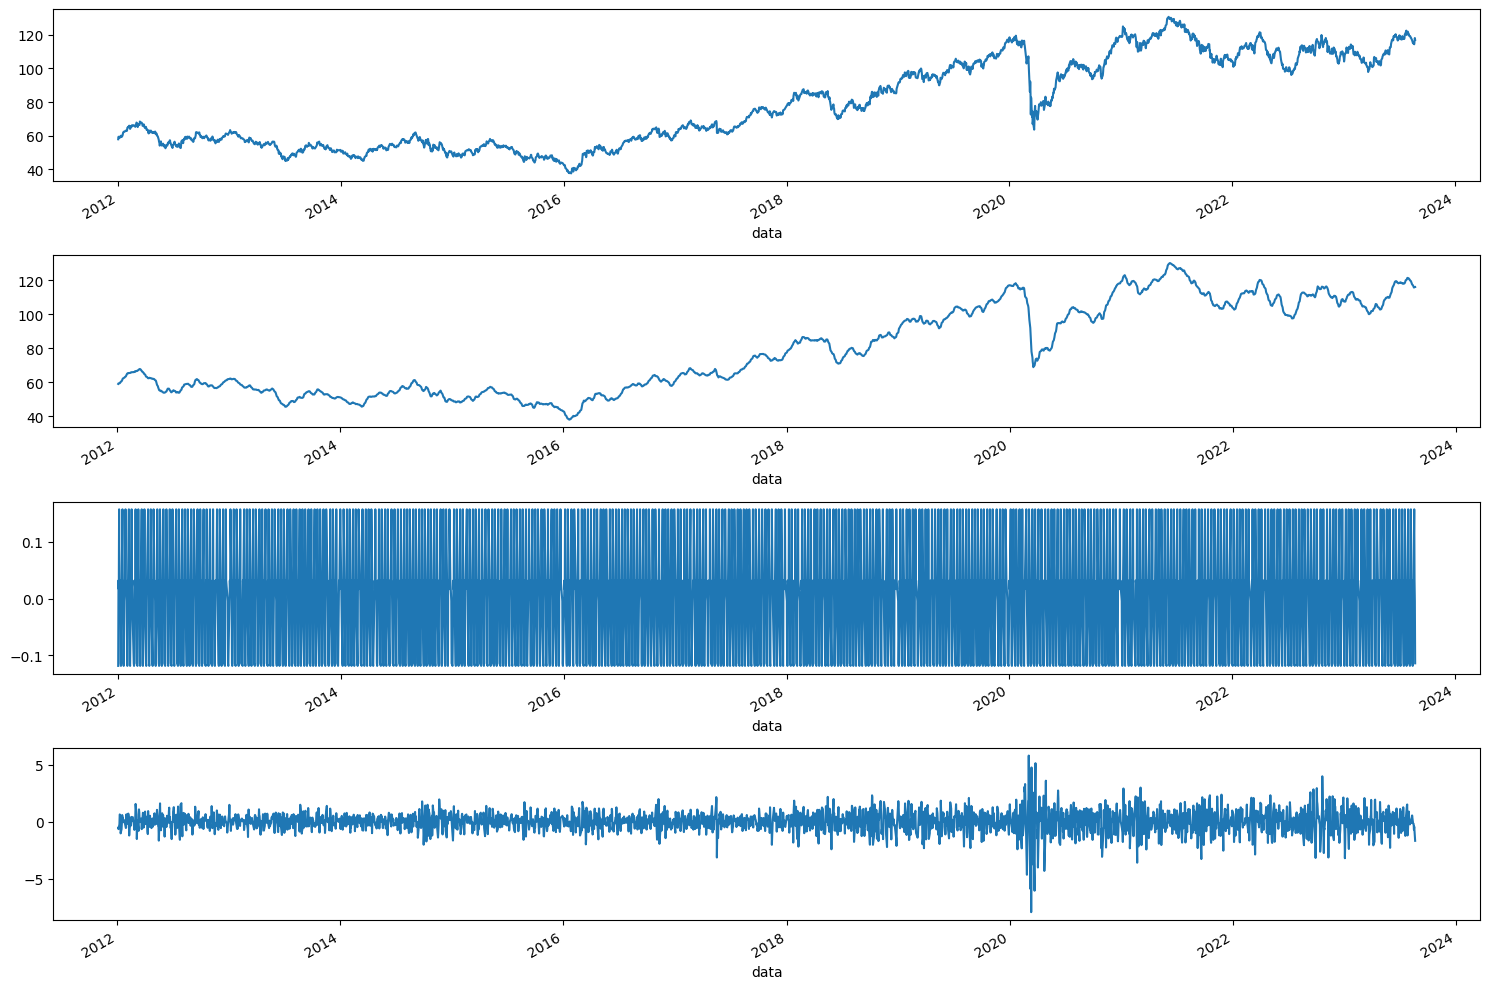

In [833]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 10))
resultados.observed.plot(ax = ax1)
resultados.trend.plot(ax = ax2)
resultados.seasonal.plot(ax = ax3)
resultados.resid.plot(ax = ax4)
plt.tight_layout()

In [834]:
ma_semanal = df_fechamento.rolling(5).mean().rename(columns = {'fechamento': 'Média móvel semanal'})
ma_anual = df_fechamento.rolling(52).mean()

fig = px.line(ma_semanal, width = 800, height = 600)
fig.add_scatter(x = ma_anual.index, y = ma_anual.fechamento, name = 'Média móvel anual')

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento',
    legend_title = 'Legenda'
)

fig.show()

In [835]:
df_log = np.log(df_fechamento).rename(columns = {'fechamento': 'Fechamento'})
ma_log = df_log.rolling(52).mean()

fig = px.line(df_log, width = 800, height = 600)
fig.add_scatter(x = ma_log.index, y = ma_log.Fechamento, name = 'Média móvel anual')

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento',
    legend_title = 'Legenda',
)

fig.show()

In [836]:
df_log = np.log(df_fechamento)
ma_log = df_log.rolling(12).mean()

df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(12).mean()
std_s = df_s.rolling(12).std()

'''f, ax = plt.subplots(figsize = (8, 5))
df_s.plot(ax = ax, legend = False)
ma_s.plot(ax = ax, legend = False, color = 'r')
std_s.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()'''

fig = make_subplots(rows = 1, cols = 3, subplot_titles = ('Plot 1', 'Plot 1', 'Plot 1'))

fig.add_trace(go.Scatter(x = df_s.index, y = df_s.fechamento), row = 1, col = 1)
fig.add_trace(go.Scatter(x = ma_s.index, y = ma_s.fechamento), row = 1, col = 2)
fig.add_trace(go.Scatter(x = std_s.index, y = std_s.fechamento), row = 1, col = 3)


fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento'
)

fig.show()

In [837]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

'''f, ax = plt.subplots(figsize = (8, 5))
df_diff.plot(ax = ax, legend = False)
ma_diff.plot(ax = ax, legend = False, color = 'r')
std_diff.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()'''

from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(rows = 1, cols = 3)

fig.add_trace(go.Scatter(x = df_diff.index, y = df_diff.fechamento), row = 1, col = 1)
fig.add_trace(go.Scatter(x = ma_diff.index, y = ma_diff.fechamento), row = 1, col = 2)
fig.add_trace(go.Scatter(x = std_diff.index, y = std_diff.fechamento), row = 1, col = 3)


fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento'
)

fig.show()

## Teste estatístico de estacionariedade para a variável target

Uma série temporal é dita estacionária se suas propriedades (média, variância, etc.) não dependem do tempo da observação. Portanto, séries que apresentam tendência ou sazonalidade não são estacionárias. Por outro lado, uma série composta por valores gerados aleatoriamente são estacionárias, visto que a “aparência” da série é basicamente a mesma para qualquer período t.

### ADF - Augmented Dickey-Fuller

>H0 - Hipótese Nula (não é estacionária)

>H1 - Hipótese Alternativa (rejeita a hipótese nula)

**p-valor <= 0.05 rejeitamos H0 com um nível de confiança de 95%**

In [838]:
from statsmodels.tsa.stattools import adfuller


X = df.fechamento.values

result = adfuller(X)

print('Teste ADF')
print(f'Teste estatístico: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste estatístico: -0.9773210531544592
P-valor: 0.7614458026930175
Valores críticos:
	1%: -3.4326257810090195
	5%: -2.862545485752566
	10%: -2.567305249201584


### ARIMA - AR (autoregressivo) I (integrado) MA (média móvel)

#### A (x, y, z) -> ACF, PACF

In [839]:
lag_acf = acf(df_diff.dropna(), nlags = 25) #trabalhando na base mensal
lag_pacf = pacf(df_diff.dropna(), nlags = 25)

### 5% ACF

##### 1.96 / sqrt(N - d) -> N (número de pontos da base), d (número de vezes que diferenciamos a base)

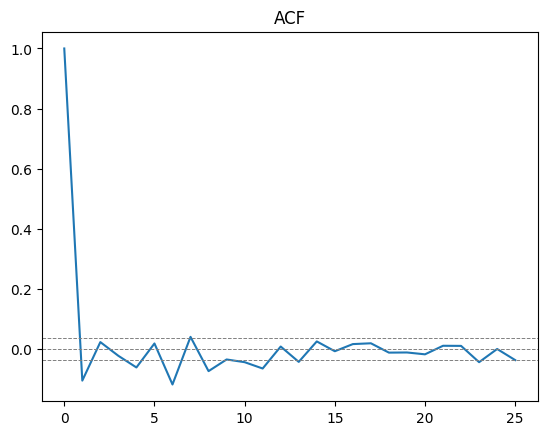

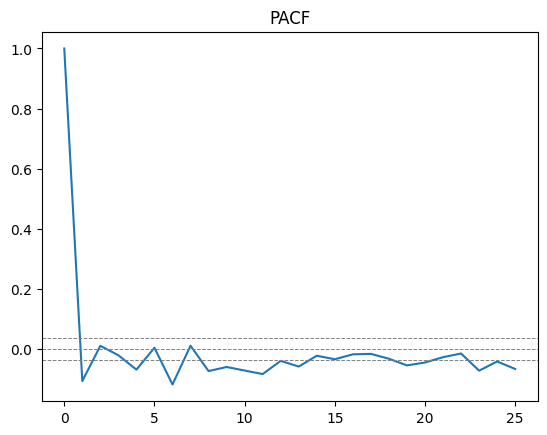

In [840]:
plt.plot(lag_acf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('ACF')
plt.show()

plt.plot(lag_pacf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) - 1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) - 1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('PACF')
plt.show()

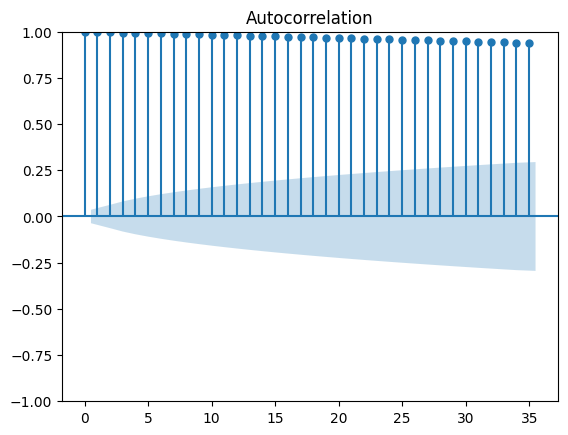

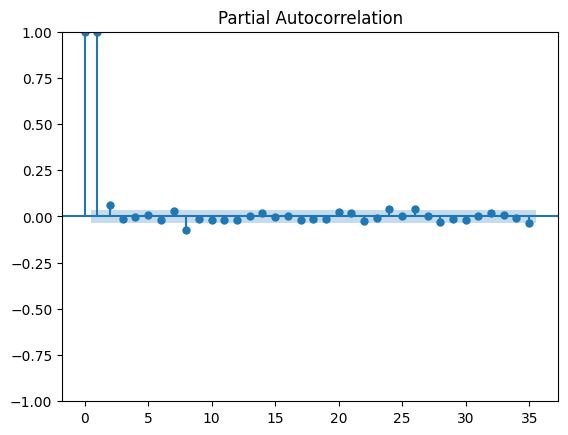

In [841]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.fechamento)
plot_pacf(df.fechamento)
plt.show()

## Modelando

In [842]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [843]:
df_diff.reset_index(inplace = True)
df_diff = df_diff[['data', 'fechamento']].rename(columns = {'data': 'ds', 'fechamento': 'y'})
df_diff['unique_id'] = 'Fechamento'
df_diff.dropna(inplace = True)
df_diff.head()

,ds,y,unique_id
1,2012-01-18,0.012172,Fechamento
2,2012-01-19,-0.000362,Fechamento
3,2012-01-20,0.002160,Fechamento
4,2012-01-23,-0.004107,Fechamento
5,2012-01-24,-0.003749,Fechamento


In [844]:
df_diff.shape

(2872, 3)

In [845]:
df.reset_index(inplace = True)
df = df[['data', 'fechamento']].rename(columns = {'data': 'ds', 'fechamento': 'y'})
df['unique_id'] = 'Fechamento'
df.dropna(inplace = True)
df.head()

,ds,y,unique_id
0,2012-01-02,57.829,Fechamento
1,2012-01-03,59.265,Fechamento
2,2012-01-04,59.365,Fechamento
3,2012-01-05,58.546,Fechamento
4,2012-01-06,58.600,Fechamento


In [846]:
df.shape

(2884, 3)

### Modelo baseline

In [847]:
from statsforecast import StatsForecast
from statsforecast.models import Naive

In [848]:
treino_diff = df_diff.loc[(df_diff['ds'] >= '2013-01-01') & (df_diff['ds'] < '2023-01-01')] #dados de treino
valid_diff = df_diff.loc[(df_diff['ds'] >= '2023-01-01') & (df_diff['ds'] < '2023-03-09')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)
h = valid_diff['ds'].nunique() #datas distintas no intervalo (90 dias)
h

46

In [849]:
treino = df.loc[(df['ds'] >= '2013-01-01') & (df['ds'] < '2023-01-01')] #dados de treino
valid = df.loc[(df['ds'] >= '2023-01-01') & (df['ds'] < '2023-03-09')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)
h = valid['ds'].nunique() #datas distintas no intervalo (90 dias)
h

46

In [850]:
t1 = df.loc[(df['ds'] >= '2013-01-01') & (df['ds'] < '2015-01-01')] 
t2 = df.loc[(df['ds'] >= '2015-01-01') & (df['ds'] < '2017-01-01')]
t3 = df.loc[(df['ds'] >= '2017-01-01') & (df['ds'] < '2019-01-01')]
t4 = df.loc[(df['ds'] >= '2019-01-01') & (df['ds'] < '2021-01-01')]
t5 = df.loc[(df['ds'] >= '2021-01-01') & (df['ds'] < '2023-01-01')]

valid_1 = df.loc[(df['ds'] >= '2015-01-01') & (df['ds'] < '2020-01-01')]
valid_2 = df.loc[(df['ds'] >= '2017-01-01') & (df['ds'] < '2017-02-01')]
valid_3 = df.loc[(df['ds'] >= '2019-01-01') & (df['ds'] < '2019-02-01')]
valid_4 = df.loc[(df['ds'] >= '2021-01-01') & (df['ds'] < '2021-02-01')]
valid_5 = df.loc[(df['ds'] >= '2023-01-01') & (df['ds'] < '2023-02-01')]

h_1 = valid_1['ds'].nunique() #datas distintas no intervalo (90 dias)
h_2 = valid_2['ds'].nunique() #datas distintas no intervalo (90 dias)
h_3 = valid_3['ds'].nunique() #datas distintas no intervalo (90 dias)
h_4 = valid_4['ds'].nunique() #datas distintas no intervalo (90 dias)
h_5 = valid_5['ds'].nunique() #datas distintas no intervalo (90 dias)

'''treino_teste = pd.concat([t1, t2], ignore_index = True)
treino_teste = pd.concat([treino_teste, t3], ignore_index = True)
valid_teste = df.loc[(df['ds'] >= '2019-01-01') & (df['ds'] < '2019-04-01')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)
h = valid_teste['ds'].nunique() #datas distintas no intervalo (90 dias)
h'''

"treino_teste = pd.concat([t1, t2], ignore_index = True)\ntreino_teste = pd.concat([treino_teste, t3], ignore_index = True)\nvalid_teste = df.loc[(df['ds'] >= '2019-01-01') & (df['ds'] < '2019-04-01')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)\nh = valid_teste['ds'].nunique() #datas distintas no intervalo (90 dias)\nh"

In [851]:
valid_diff.shape, treino_diff.shape

((46, 3), (2475, 3))

In [852]:
valid.shape, treino.shape

((46, 3), (2475, 3))

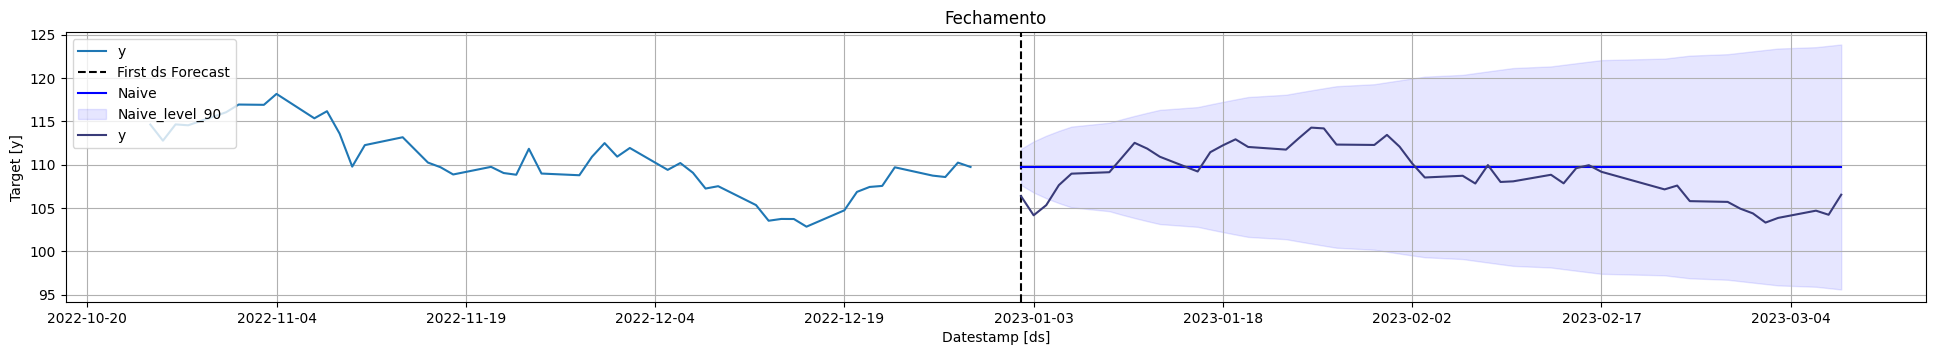

In [853]:
model = StatsForecast(
    models = [Naive()], 
    freq = 'D', 
    n_jobs = -1
) #n_jobs, quantidade de CPUs da máquina que será ultilizada

model.fit(treino)
forecast_df = model.predict(h = h, level = [90]) #level é a banda de confiança estabelecida
forecast_df.ds = valid.ds.to_list()
forecast_df = forecast_df.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model.plot(treino, forecast_df, level = [90], engine = 'matplotlib', max_insample_length = 46)

In [854]:
wmape_baseline = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f'WMAPE: {wmape_baseline:.2%}')

WMAPE: 2.40%


In [855]:
forecast_df.head()

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,y
0,Fechamento,2023-01-02,109.735001,107.653687,111.816315,106.376
1,Fechamento,2023-01-03,109.735001,106.791580,112.678421,104.166
2,Fechamento,2023-01-04,109.735001,106.130058,113.339943,105.334
3,Fechamento,2023-01-05,109.735001,105.572372,113.897629,107.641
4,Fechamento,2023-01-06,109.735001,105.081039,114.388962,108.964


### Modelo baseline com sazonalidade

In [856]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive

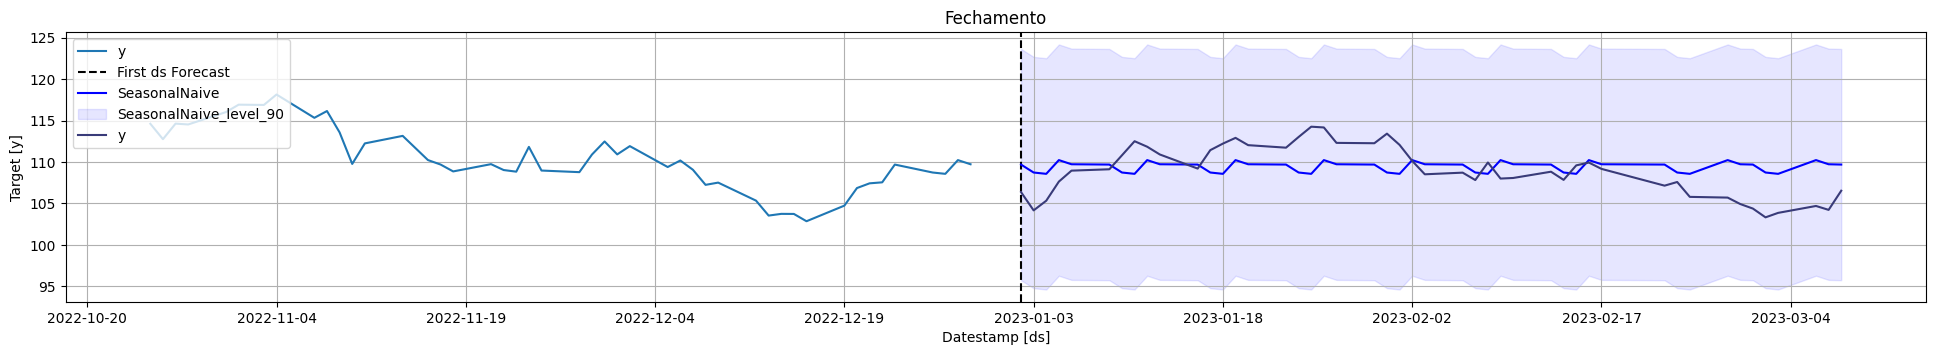

In [857]:
model_s = StatsForecast(models = [SeasonalNaive(season_length = 5)], freq = 'D', n_jobs = -1) #o parâmetro season_length é o padrão que se deseja estabelecer
model_s.fit(treino)
forecast_dfs = model_s.predict(h = h, level = [90])
forecast_dfs.ds = valid.ds.to_list()
forecast_dfs = forecast_dfs.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model_s.plot(treino, forecast_dfs, level = [90], engine = 'matplotlib', max_insample_length = 46)

In [858]:
wmape_s = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f'WMAPE: {wmape_s:.2%}')

WMAPE: 2.44%


In [859]:
forecast_dfs.head()

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,y
0,Fechamento,2023-01-02,109.697998,95.738808,123.657188,106.376
1,Fechamento,2023-01-03,108.737999,94.778809,122.697189,104.166
2,Fechamento,2023-01-04,108.578003,94.618813,122.537193,105.334
3,Fechamento,2023-01-05,110.237000,96.277809,124.196190,107.641
4,Fechamento,2023-01-06,109.735001,95.775810,123.694191,108.964


### Modelo baseline com sazonalidade e média móvel

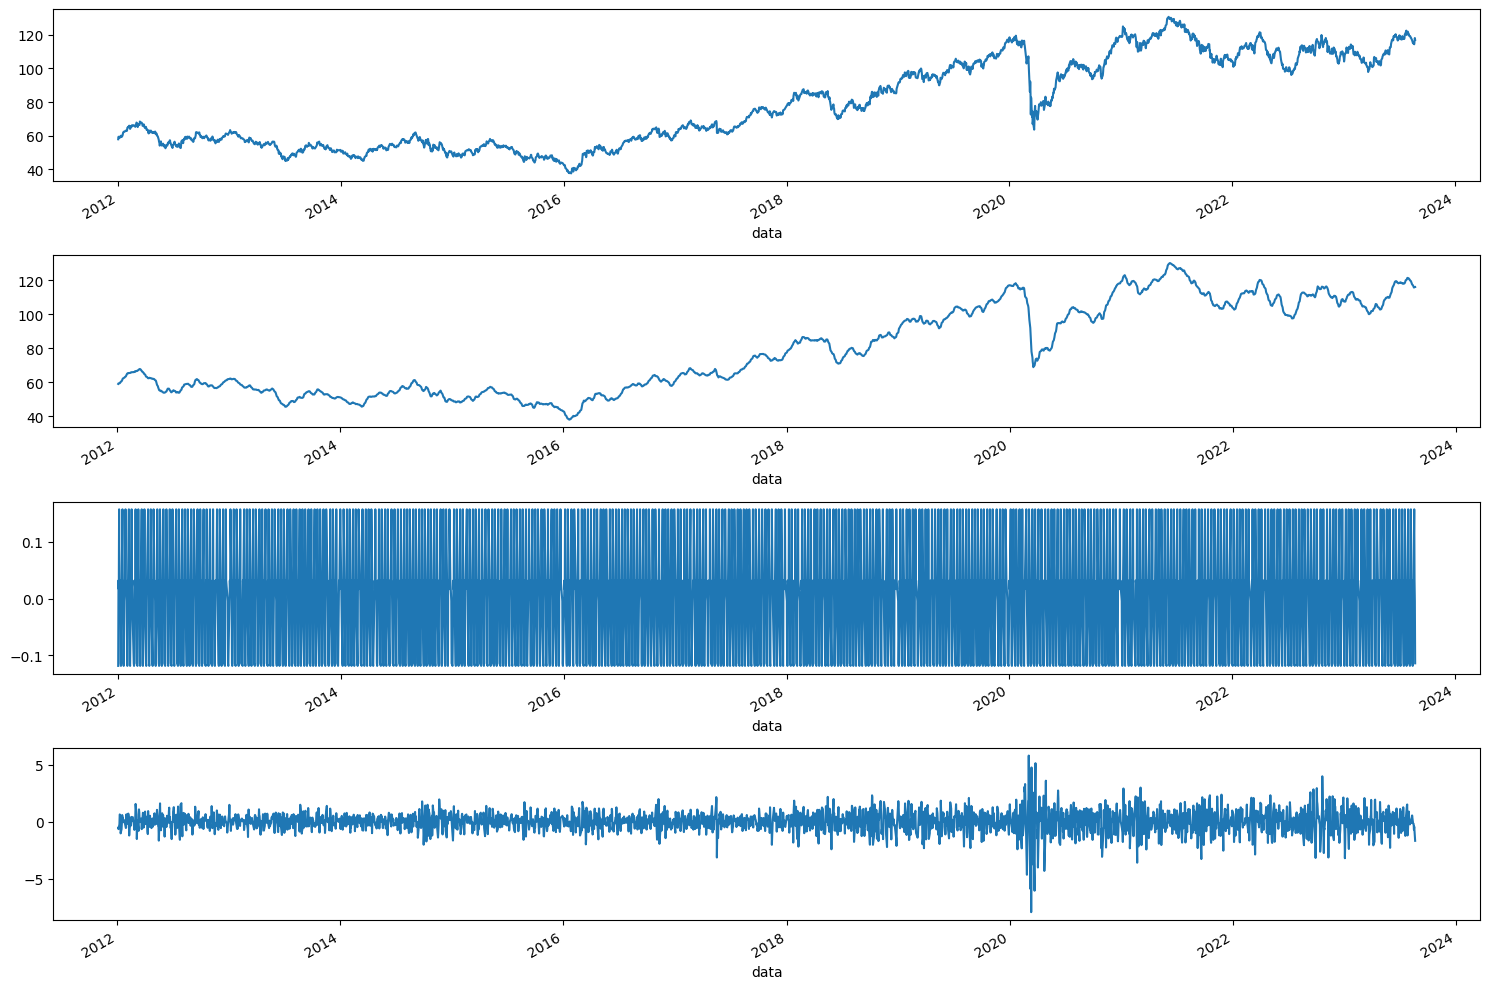

In [860]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 10))
resultados.observed.plot(ax = ax1)
resultados.trend.plot(ax = ax2)
resultados.seasonal.plot(ax = ax3)
resultados.resid.plot(ax = ax4)
plt.tight_layout()

In [861]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage

In [862]:
h_1

1233

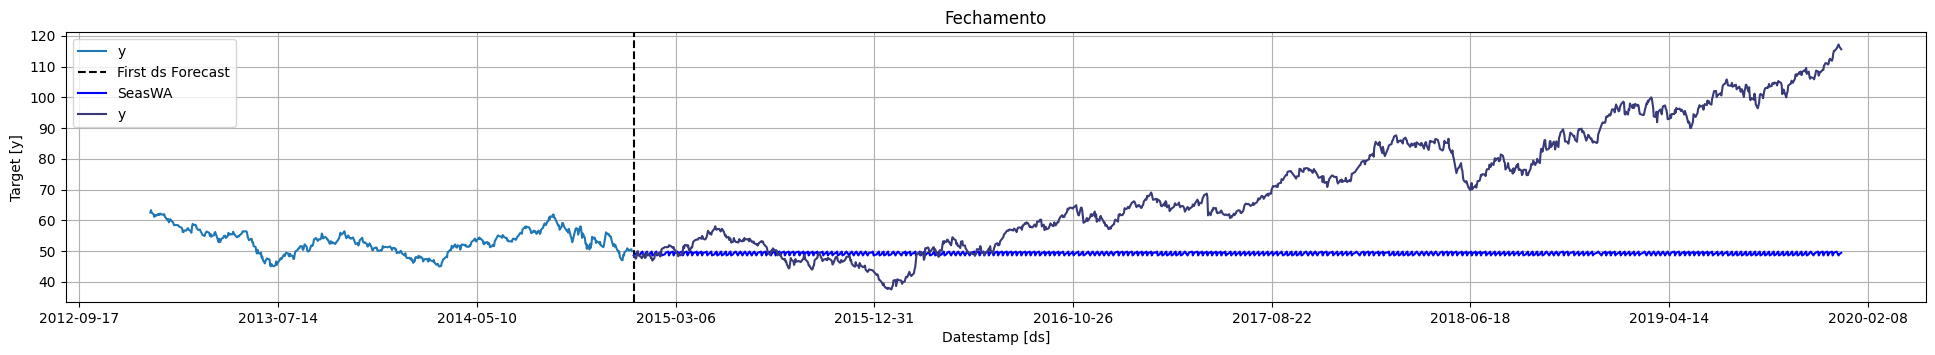

In [863]:
model_sm = StatsForecast(models = [SeasonalWindowAverage(season_length = 5, window_size = 2)], freq = 'D', n_jobs = -1) #o parâmetro window_size é período em que será calculada a média móvel (2 semanas)
model_sm.fit(t1)
forecast_dfsm = model_sm.predict(h = h_1, level = [90])
forecast_dfsm.ds = valid_1.ds.to_list()
forecast_dfsm = forecast_dfsm.reset_index().merge(valid_1, on = ['ds', 'unique_id'], how = 'left')
model_sm.plot(t1, forecast_dfsm, level = [90], engine = 'matplotlib', max_insample_length = h_1)

In [864]:
wmape_sm = wmape(forecast_dfsm['y'].values, forecast_dfsm['SeasWA'].values)
print(f'WMAPE: {wmape_sm:.2%}')

WMAPE: 31.84%


In [865]:
forecast_dfsm.head()

,unique_id,ds,SeasWA,y
0,Fechamento,2015-01-02,48.570000,48.512
1,Fechamento,2015-01-05,48.948997,47.517
2,Fechamento,2015-01-06,49.429501,48.001
3,Fechamento,2015-01-07,49.544998,49.463
4,Fechamento,2015-01-08,49.829002,49.943


### Modelo ARIMA

In [866]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

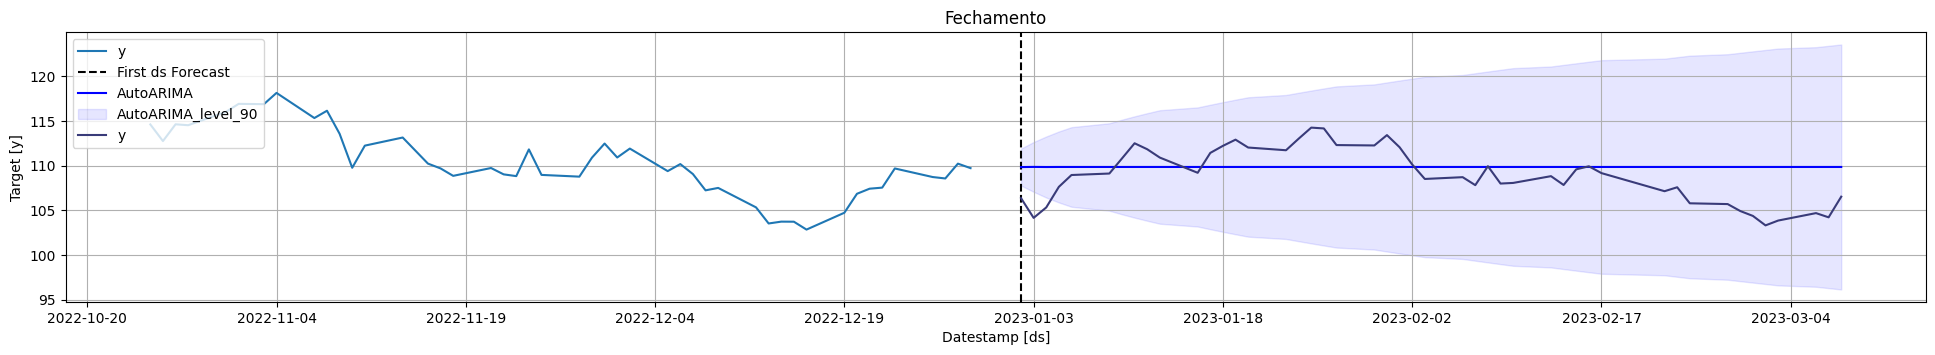

In [867]:
model_a = StatsForecast(models = [AutoARIMA(season_length = 5)], freq = 'D', n_jobs = -1)
model_a.fit(treino)
forecast_dfa = model_a.predict(h = h, level = [90])
forecast_dfa.ds = valid.ds.to_list()
forecast_dfa = forecast_dfa.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model_a.plot(treino, forecast_dfa, level = [90], engine = 'matplotlib', max_insample_length = 46)

In [868]:
wmape_a = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f'WMAPE: {wmape_a:.2%}')

WMAPE: 2.42%


In [869]:
forecast_dfa.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,Fechamento,2023-01-02,109.853462,107.784286,111.922630,106.376
1,Fechamento,2023-01-03,109.871490,107.084793,112.658180,104.166
2,Fechamento,2023-01-04,109.859261,106.441269,113.277252,105.334
3,Fechamento,2023-01-05,109.864983,105.892647,113.837326,107.641
4,Fechamento,2023-01-06,109.864441,105.408760,114.320129,108.964


### Auto ARIMA

In [870]:
from pmdarima.arima import auto_arima

In [871]:
stepwise_model = auto_arima(df.drop('unique_id', axis = 1).set_index('ds', drop = True), start_p = 1, start_q = 1,
                           max_p = 3, max_q = 3, m = 12,
                           start_P = 0, seasonal = True,
                           d = 1, D = 1, trace = True,
                           error_action = 'ignore',  
                           suppress_warnings = True, 
                           stepwise = True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=12.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=11341.144, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=10489.947, Time=1.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=9.84 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=11322.203, Time=0.36 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=10176.794, Time=2.73 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=32.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=8.71 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=10192.827, Time=2.25 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=10177.483, Time=3.32 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=10177.678, Time=4.00 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=10177.634, Time=3.76 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=10179.483, Time=5.71 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=10178.779, Time=12.32 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
Total fit time: 99.00

In [872]:
treino_autoarima = treino.drop('unique_id', axis = 1).set_index('ds', drop = True)
stepwise_model.fit(treino_autoarima)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [873]:
future_forecast = stepwise_model.predict(n_periods = 46)

In [874]:
valid.head()

,ds,y,unique_id
2721,2023-01-02,106.376,Fechamento
2722,2023-01-03,104.166,Fechamento
2723,2023-01-04,105.334,Fechamento
2724,2023-01-05,107.641,Fechamento
2725,2023-01-06,108.964,Fechamento


In [875]:
valid_autoarima = valid
valid_autoarima.drop('unique_id', axis = 1, inplace = True)
valid_autoarima.set_index('ds', inplace = True)

In [876]:
valid_autoarima.shape, future_forecast.shape

((46, 1), (46,))

In [877]:
wmape_a = wmape(valid_autoarima.values, future_forecast.values)
print(f'WMAPE: {wmape_a:.2%}')

WMAPE: 111.51%


In [878]:
future_forecast = pd.DataFrame(future_forecast.values, index = valid_autoarima.index, columns = ['Prediction'])
valid_autoarima = valid_autoarima.rename(columns = {'y': 'Fechamento'})

fig = px.line(valid, width = 800, height = 600)
fig.add_scatter(x = future_forecast.index, y = future_forecast.Prediction, name = 'Previsão')

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento',
    legend_title = 'Legenda'
)

fig.show()

### Prophet

In [879]:
from prophet import Prophet

In [880]:
treino_prophet = treino.reset_index(drop = True).drop('unique_id', axis = 1)
valid_prophet = valid
h

46

In [887]:
treino_prophet.head()

,ds,y
0,2013-01-02,62.550
1,2013-01-03,63.312
2,2013-01-04,62.523
3,2013-01-07,61.933
4,2013-01-08,61.128


In [882]:
m = Prophet()
m.fit(treino_prophet)

22:50:09 - cmdstanpy - INFO - Chain [1] start processing
22:50:11 - cmdstanpy - INFO - Chain [1] done processing


In [883]:
future = m.make_future_dataframe(periods = 46, include_history = False)

In [884]:
forecast_prophet = m.predict(future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2022-12-30,107.807387,101.120658,114.657177
1,2022-12-31,110.612008,103.034092,117.533323
2,2023-01-01,110.734256,103.400074,117.792943
3,2023-01-02,108.163118,101.232486,114.775467
4,2023-01-03,108.227373,101.717663,115.327481


In [ ]:
forecast_prophet = forecast_prophet[['ds', 'yhat']].set_index('ds')
forecast_prophet.index = valid_prophet.index
forecast_prophet.head()

,yhat
ds,
2023-01-02,107.846078
2023-01-03,110.494314
2023-01-04,110.615263
2023-01-05,108.218171
2023-01-06,108.281581


In [ ]:
wmape_a = wmape(valid_prophet['y'].values, forecast_prophet['yhat'].values)
print(f'WMAPE: {wmape_a:.2%}')

WMAPE: 2.57%


In [ ]:
valid_prophet = valid_prophet.rename(columns = {'y': 'Fechamento'})

fig = px.line(valid_prophet, width = 800, height = 600)
fig.add_scatter(x = forecast_prophet.index, y = forecast_prophet.yhat, name = 'Previsão')

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento',
    legend_title = 'Legenda'
)

fig.show()